## Chapter 3 [Imaging](Ch3-Imaging.ipynb)


<hr style="height:1px;border-top:4px solid #FF8200" />

# Contrast Transfer Function


part of 

## [Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes
part of 


In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook

# our blob detectors from the scipy image package
from skimage.feature import blob_dog, blob_log, blob_doh
# Multidimensional Image library
import scipy.ndimage as ndimage

import time
# Import libraries from the book
import pyTEMlib
import pyTEMlib.file_tools as ft          # File input/ output library
import pyTEM.TEMlib.KinsCat as ks         # Kinematic sCattering Library


# The file format we use is pyUSID
import pyUSID as usid
import h5py as hf5

# it is a good idea to show the version numbers at this point for archiving reasons.
print('pyUSID version: ',usid.__version__)
print('pyTEM version: ',pyTEMlib.__version__)

%gui qt

Populating the interactive namespace from numpy and matplotlib
windows
Using KinsCat library version  0.5  by G.Duscher
Symmetry functions of spglib enabled
pyUSID version:  0.0.4
pyTEM version:  0.3.2019


# Resolution limit 

### Raleigh classical criterion
> smallest distance which can be resolved\\
>> **Point Resolution**

<img src="images/RayleighCriterion.jpg">

$$\delta = 0.61 \frac{ \lambda }{\mu\  \sin\  \beta}$$
with
$\lambda$ = wavelength;
$\mu$  = refractive index $\approx$ 1;
$\beta$ = collection semi angle $\approx$ small;

$$\delta \approx 0.5 \lambda$$


green light: 550 nm  $\Longrightarrow$ 300 nm is best resolution: about 1000 atoms

>Is that good good enough?

>>Better resolutions with microscopes with smaller $\lambda$  and/or bigger $\mu$.

>How about X-rays or neutrons? 
>>These waves/particles have a smaller wavelength than light, but there are no lenses for them. <br>That leaves us with the electrons and ions.


### Electron


De Broglie wavelength of electrons accelerated with  200keV is about  $\lambda = 2.4$ pm. The Raleigh criterium would therefore suggest a resoltuion of 1.2 pm: : much less than diameters of atoms.


### Lens Aberrations

This theoretical resolution is not achieved so far, because electro-magnetic lenses are as bad as
* bottom of champagne bottle (Europe)\
* bottom of coke bottle (US)\\

> **We need to look into the aberrations of lenses if we want to understand resolution in the TEM**


# Aberrations


|Notation | Order of ray aberr. |Order of wave aberr.| Name | Symmetry|
|---|---|---|---|---|	
|C$_{01A}$ | 0 | 1 | Probe shift in x direction | 1--fold|
|C$_{01B}$ | 0 | 1 | Probe shift in y direction | 1--fold|
|C$_{1}$   | 1 | 2 | Defocus                    | Rotational|
|C$_{12}$  | 1 | 2 | Astigmatism                | 2--fold|
|C$_{21}$  | 2 | 3 | Coma                       | 1--fold|
|C$_{23}$  | 2 | 3 | 3-fold astigmatism         | 3--fold|
|C$_{3}$   | 3 | 4 | Spherical aberration (C$_s$)| Rotational|
|C$_{32}$  | 3 | 4 | 2--fold astig of C$_s$     | 3--fold|
|C$_{34}$  | 3 | 4 | 4--fold astig of C$_s$     | 3--fold|


# Aberrations and Contrast Transfer Function

We set typical values for our TEM (Zeiss Libbra 200MC)


In [2]:
acceleration_voltage_V = 200*1e3 # Microscope voltage in V
C_s=2.2 # Spherical abberation coefficient in mm
defocus = -90 # Microscope defocus in nm
Cc=2.0 # Chromatic abberation coefficient in mm

## Contrast Transfer Function
The aberation function with all the aberration in teh table above is 

With the above notation the aberration function is expressed as:
\begin{eqnarray}
\Large
\chi(\rho, \phi) 
&= \{ \rho &[ C_{01A}\cos(\phi)+C_{01B}\sin(\phi)]\\
&+  \frac{\rho^2}{2}&[C_1+C_{12A}\cos(2\phi)+C_{12B}\sin(2\phi)]+\nonumber \\
&+ \frac{\rho^3}{3}&[C_{21A}\cos(\phi)+C_{21B}\sin(\phi)+
C_{23A}\cos(3\phi)+C_{23B}\sin(3\phi)]+\nonumber \\
&+ \frac{\rho^4}{4}&[C_3+C_{32A}\cos(2\phi)+C_{32B}\sin(2\phi)+
C_{34A}\cos(4\phi)+C_{34B}\sin(4\phi)]+ \nonumber\\
&+& ...\}\nonumber
\end{eqnarray}

For an uncorrected microscope the defocus $\Delta f$ and the spherical aberration $C_s = C_3$ are the resolution limiting parameter. The aberration function reduces to:

$$\chi(k)=\frac{\pi}{2}C_s\lambda^3k^4-\pi \Delta f \lambda k^2$$

The deBrouglie wave length  of the electrons $\lambda$ is calculated from the acceleration voltage as in the 
[The Electron](Electron.ipynb)

The functions that tells us what spatial frequencies are transfered from  object to  image is called the 
**Contrast Transfer Function** (CTF).

$$CTF(k)=A(k)E(k)\sin(\chi(k))$$

With $A$: objective aperture function; $E$: envelope or damping function; $\chi$ aberration function.

One aims for a rather flat aberration function for as long a range of spatial frequency as possible: 
The function $\sin(\xi)$ is flat if  $\frac{d\xi}{du}$ is zero.

$$\frac{d \chi(u)}{du} = 2 \pi \Delta f \lambda u + 2 \pi C_{s} \lambda^3  u^3$$

We set the left term to zero to get the flat portion and get:

$$0 =  \Delta f  +  C_{s} \lambda^2  u^2$$

When $\chi $  is $-120^{\rm o}$ (or $-2\pi/3$) we get:

$$-\frac{2}{3}\pi = \pi \Delta f \lambda u^2 + \frac{1}{2} \pi C_{s} \lambda^3  u^4$$




##  Scherzer Focus
Combining the two equations gives a certain defocus value the Scherzer focus:

$$ \Delta f_{Sch}  =  -\sqrt{\frac{3}{2}C_{s} \lambda} = -1.2 \sqrt{C_{s} \lambda}$$

In [3]:
acceleration_voltage_V = 200*1e3 # Microscope voltage in V
Cs=2.2 # Spherical abberation coefficient in mm
defocus = -90 # Microscope defocus in nm
Cc=2.0 # Chromatic abberation coefficient in mm

In [4]:
def calculateScherzer(waveLength, Cs):
    # Calculate the Scherzer defocus. Cs is in mm, lambda is in nm
    # Everything is trasnfered to m
    #The returned value is in nm
    Cs=Cs*1e6 # now in nm
    scherzer= -np.sqrt(3/2*Cs*waveLength) # in nm    
    return scherzer

waveLength = ks.get_waveLength(acceleration_voltage_V) # in nm

scherzer =calculateScherzer(waveLength, C_s)

print(f'Scherzer defocus is {scherzer:.1f} nm')

Scherzer defocus is -91.0 nm


## Point Resolution

The point resolution of a microscope is defined as the spatial frequency ''u''<sub>res</sub> 
where the CTF crosses the abscissa for the first time. At Scherzer defocus this value is maximized:

$$u_\text{res}(\text{Scherzer})=0.6\lambda^{3/4} C_s^{1/4}$$

Contributions with a spatial frequency higher than the point resolution can be filtered out with an appropriate aperture leading to easily interpretable images at the cost of a lot of information lost.


In [5]:
# Calculate the resolution at Scherzer defocus, Cs is in mm, lambda is in nm
# The returned value is in nm

def calculateresatscherzer(waveLength, Cs):
    Cs=Cs*1e6 # now in nm
    waveLength = waveLength 
    scherzerres=0.64 * waveLength**0.75 * Cs**0.25
    return scherzerres

scherzer_resolution = calculateresatscherzer(waveLength, C_s)

print(f'Point resolution (at Scherzer focus) is {scherzer_resolution:.2f} nm')

Point resolution (at Scherzer focus) is 0.28 nm


## Contrast transfer function
Now we plot the CTF for Scherzer defocus for spatial frequencies $u$ (distances in k- or reciprocal space):
$$\chi(u)=\frac{\pi}{2}C_s\lambda^3u^4-\pi \Delta f \lambda u^2$$

>Please note that we will see the square of the CTF: CTF$^2$ in the intensity of the images.

<IPython.core.display.Javascript object>


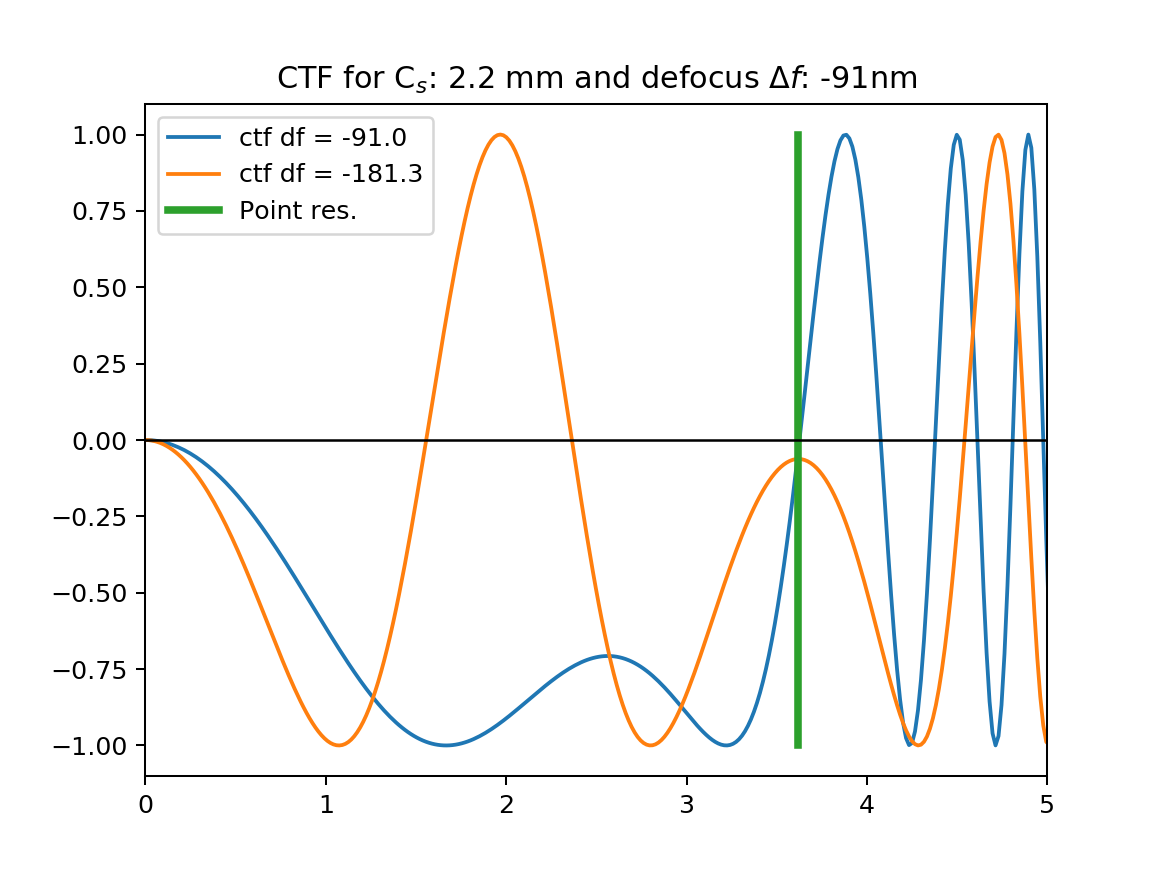

(0, 5)

In [6]:
defocus = scherzer

waveLength = ks.get_waveLength(acceleration_voltage_V)
ref_scale_x = 0.016537397801242235
u = np.linspace(0,1023,1024)*ref_scale_x
def calculateCTF(waveLength, Cs, defocus,u):
    # everything in nm
    Cs=Cs*10**6
    ctf=np.sin(np.pi*defocus*waveLength*u**2+0.5*np.pi*Cs*waveLength**3*u**4)
    return ctf

defocus2 = defocus*2+0.6
ctf = calculateCTF(waveLength, Cs, defocus,u)
ctf2= calculateCTF(waveLength, Cs, defocus2,u)
plt.figure()
plt.title(f'CTF for C$_s$: {C_s:.1f} mm and defocus $\Delta f$: {defocus:.0f}nm')
plt.plot(u,ctf, label = f'ctf df = {defocus:.1f}')
plt.plot(u,ctf2, label = f'ctf df = {defocus2:.1f}')
plt.plot([1/scherzer_resolution,1/scherzer_resolution],[-1,1],linewidth = 3, label ='Point res.')
plt.plot([0,10],[0,0],linewidth = 1, c='black')
plt.legend(loc=0)
plt.xlim(0,5)

# Stability Parameters and Dampening of CTF

For stability, which is expressed as a dampening of the contrast transfer function. These envelope functions are determined by the following parameters.

Experimental parameters 
* chromatic aberration $C_c$ 
* energy spread of the electron gun
* convergence angle $\alpha$

Stability parameters
* stability of the acceleration voltage 
* stability of objective lens current
* driftrate fo the sample


In [7]:
IObjStability= .1 # The objective lens stability in ppm (Delta I Obj/I Obj)*1e6
HTstability=0.1/200000*1e6  # The stabilty of the HT supply in ppm (Delta V/V)*1e6

sourcespread=0.6 #// The energy spread of the electron source in eV. 
#FEG: 0.9 eV and LaB6: 2.0 eV are typical energy spread values for these emitters
sourcealpha=0.1 # The covergence semiangle of the source in mrad
#Note FEG and LaB6 buttons provide typical alpha value for these emitters
driftrate=0.1 # The drift rate in nm/s. Note no exposure time is provided so 
#               the Edrift envelope is for a 1s exposure.

However it is the ''envelope function'' ''E('''u''')'' which usually dampens the signal of beams 
scattered at high angles, and imposes a maximum to the transmitted spatial frequency. 
This maximum determines the highest resolution attainable with a microscope and is known as the information limit. 
''E('''u''')'' can be described as a product of single envelopes:

$$E(u)=E_s(u)E_c(u)E_d(u)$$
due to

* $E_s(u)$: source envelope
* $E_c(u)$: chromatic aberration
* $E_d(u)$: specimen drift

In principle we also should consider:
* $E_v(u)$: specimen vibration
* $E_D(u)$: detector
but we generally handle that by oversampling the image (an atom is more than a pixel)


Specimen drift and vibration can be minimized in a stable environment. It is usually the spherical aberration $C_s$ that limits spatial coherency and defines $E_s(u)$ and the chromatic aberration $C_c$, together with current and voltage instabilities that define the temporal coherency in $E_c(u)$. These two envelopes determine the information limit by damping the signal transfer in Fourier space with increasing spatial frequency $u$.

$$E_s(u) = \exp\left[-\left(\frac{\pi\alpha}{\lambda}\right)^2 \left(\frac{\delta\chi(u)}{\delta u}\right)^2\right] = \exp\left[-\left(\frac{\pi\alpha}{\lambda}\right)^2(C_s\lambda^3u^3+\Delta f\lambda u)^2\right]$$

where α is the semiangle of the pencil of rays illuminating the sample. Clearly, if the wave aberration ('here represented by ''C<sub>s</sub>'' and Δ''f'') vanished, this envelope function would be a constant one. In case of an uncorrected TEM with fixed ''C<sub>s</sub>'', the damping due to this envelope function can be minimized by optimizing the defocus at which the image is recorded (Lichte defocus).

The temporal envelope function can be expressed as

$$E_c(u) = \exp\left[-\frac{1}{2}\left(\pi\lambda\delta\right)^2u^4\right]$$

Here, $\delta$ is the focal spread with the chromatic aberration $C_c$ as the parameter:

$$\delta = C_c\sqrt{4\left(\frac{\Delta I_\text{obj}}{I_\text{obj}}\right)^2 + \left(\frac{\Delta E}{V_\text{acc}}\right)^2 + \left(\frac{\Delta V_\text{acc}}{V_\text{acc}}\right)^2}$$

The terms $\Delta I_\text{obj}/I_\text{obj}$ and $\Delta V_\text{acc}/V_\text{acc}$ represent instabilities in of the total current in the magnetic lenses and the acceleration voltage. $\Delta E/V_\text{acc}$ is the energy spread of electrons emitted by the source.


<IPython.core.display.Javascript object>


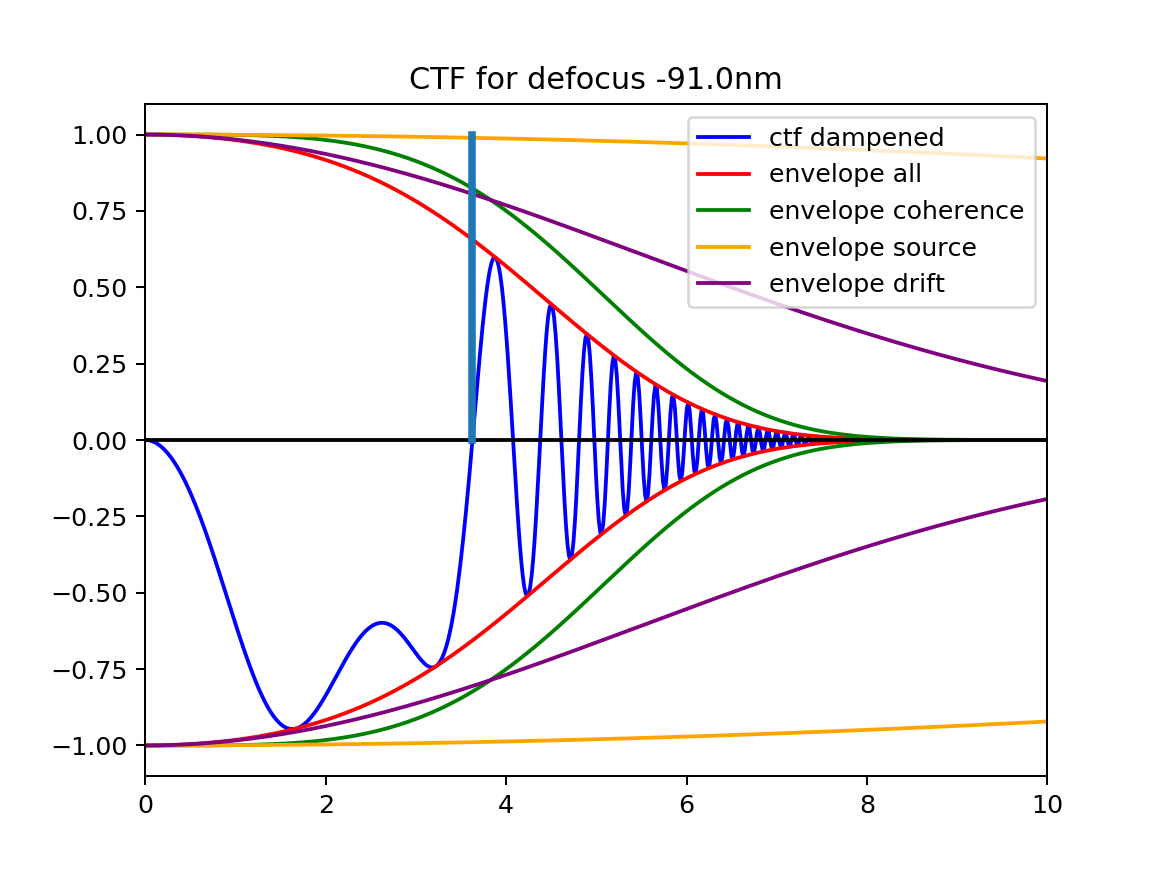

Information limit is 0.21nm 


In [8]:
defocus= scherzer

#Compute the Es function - source dependent envelope function
def sourceEnv(waveLength,sourcealpha, defocus, Cs, k):
    alpha=sourcealpha
    alpha=alpha/1e3 # convert mrads to rads
    var1=-1*((np.pi*alpha)/waveLength)**2
    EsEnv= np.exp(var1*(Cs*waveLength**3*k**3+defocus*waveLength*k)**2)
    return EsEnv


# Calculate the envelope component due to the chromatic aberration
def coherenceEnv(IObjStability, HTstability, sourcespread, Cc, voltage, waveLength, k):
    objstability=IObjStability/1e6
    envelopevoltage=voltage #// in volts
    htstability=HTstability/1e7 # in ppm
    sourceenergyspread=sourcespread  
    sourcerelativeenergyspread=sourceenergyspread/envelopevoltage
    
    Cc=Cc*1e6 #// convert to nm
    delta=Cc*(4*(objstability)**2+(sourcerelativeenergyspread)**2+(htstability)**2)**0.5

    EcEnv=np.exp(-0.5*(np.pi*(waveLength)*delta)**2*k**4)

    return EcEnv


#Compute the drift envelope function
def driftEnv(driftrate,k):
    drift=driftrate
    edEnv=np.exp(-(1/6)*(np.pi*k*drift)**2)
    return edEnv

Env_source = sourceEnv(waveLength,sourcealpha, defocus, Cs, u)
Env_coherence =  coherenceEnv(IObjStability, HTstability, sourcespread, Cc, acceleration_voltage_V, waveLength, u)
Env_drift = driftEnv(driftrate,u)

Env_total =  Env_source*Env_coherence*Env_drift
ctf = calculateCTF(waveLength, Cs, defocus,u)


##Plot CTF and Envelope functions

plt.figure()
plt.title(f'CTF for defocus {defocus:.1f}nm')
#plt.plot(k,np.abs(ctf), label = f'ctf df = {defocus:.1f}')
plt.plot(u,(ctf*Env_total), c='blue', label = f'ctf dampened')
plt.plot(u,(Env_total), c='red', label = f'envelope all')
plt.plot(u,(-Env_total), c='red')
plt.plot(u,(Env_coherence), c='green', label = f'envelope coherence')
plt.plot(u,(-Env_coherence), c='green')
plt.plot(u,(Env_source), c='orange', label = f'envelope source')
plt.plot(u,(-Env_source), c='orange')
plt.plot(u,(Env_drift), c='purple', label = f'envelope drift')
plt.plot(u,(-Env_drift), c='purple')

plt.plot([0,20], [0,0], c='black')

plt.plot([1/scherzer_resolution,1/scherzer_resolution],[0,1],linewidth = 3)
plt.legend(loc=1)
plt.xlim(0,10)
#plt.ylim(0)

print(f'Information limit is {1/u[np.argmin(np.abs(Env_total-np.exp(-1)))]:.2f}nm ')

The Diffractogram will give us the intensity and so we sill get the squared of the CTF

<IPython.core.display.Javascript object>


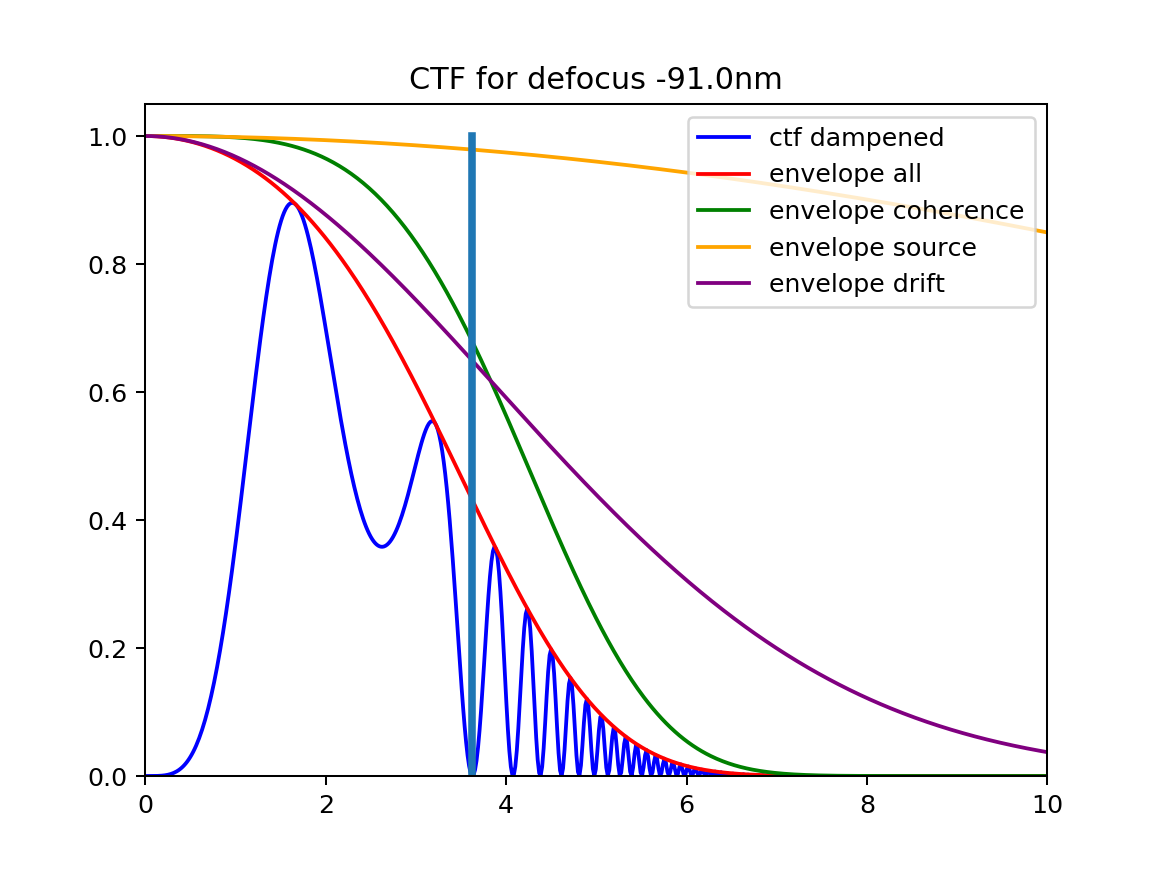

Information limit is 0.21nm 


In [9]:
##Plot CTF and Envelope functions

plt.figure()
plt.title(f'CTF for defocus {defocus:.1f}nm')
#plt.plot(k,np.abs(ctf), label = f'ctf df = {defocus:.1f}')
plt.plot(u,(ctf*Env_total)**2,c='b', label = f'ctf dampened')
plt.plot(u,(Env_total)**2,c='r', label = f'envelope all')
plt.plot(u,(Env_coherence)**2,c='g', label = f'envelope coherence')
plt.plot(u,(Env_source)**2,c='orange', label = f'envelope source')
plt.plot(u,(Env_drift)**2, c='purple', label = f'envelope drift')

plt.plot([1/scherzer_resolution,1/scherzer_resolution],[0,1],linewidth = 3)
plt.legend(loc=1)
plt.xlim(0,10)
plt.ylim(0)

print(f'Information limit is {1/u[np.argmin(np.abs(Env_total-np.exp(-1)))]:.2f}nm ')

## Conclusion:
    
The contrast transfer function allows us to evaluate the resolution capabilities of a TEM. 

In the Zeiss Libr 200MC the point resoltuion is given by the relative high spherical aberration of $C_s = 2.2$mm.

The information limit is dominated by the energy spread of the electron source (which is excellent).


## Back: [Image Processing](CH3-ImageProcessing.ipynb)
## Next: [Image Analysis](CH3-ImageAnalysis.ipynb)
## Chapter 3: [Imaging](CH3-Imaging.ipynb)
## List of Content: [Front](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)